In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [19]:
def load_domain_info():
    res = {}
    domains = ["bgmaps", "iron", "random10", "starcraft", "street", "dao", "maze512", "rooms"]
    for domain in domains:
        maps = os.listdir("./maps/%s" % domain)
        for m in maps:
            res[os.path.basename(m).removesuffix(".map")] = domain
    return res

def load_df(pth):
    map_domain = load_domain_info()
    mapname = pth.split("/")[-1]
    df = pd.read_csv(pth, sep="\t")
    df["map"] = mapname.removesuffix(".log").removesuffix(".map").split("/")[-1]
    df["domain"] = df.apply(lambda x: map_domain.get(x["map"], "sythetic"), axis=1)
    df["scnt"] += 1
    return df

# Synthetic experiment

In [33]:
jps = pd.concat([load_df("small_output_rebuttal/jps/"+i) for i in os.listdir("small_output_rebuttal/jps")])
jpsp = pd.concat([load_df("small_output_rebuttal/jps-prune/"+i) for i in os.listdir("small_output_rebuttal/jps-prune")])
jpss = pd.concat([load_df("small_output_rebuttal/jps-simple/"+i) for i in os.listdir("small_output_rebuttal/jps-simple")])
# jps2 = pd.concat([load_df("small_output/jps2/"+i) for i in os.listdir("small_output/jps2")])
# jps2p = pd.concat([load_df("small_output/jps2-prune/"+i) for i in os.listdir("small_output/jps2-prune")])
# df = pd.DataFrame.merge(jpsp, jps, on=["id", "map", "domain"], suffixes=("", "_jps"))
# df = pd.DataFrame.merge(jpsp, jps, on=["id", "map", "domain"], suffixes=("", "_jps"))
df = pd.DataFrame.merge(jpsp, jps, on=["id", "map", "domain"], suffixes=("", "_jps"))
# sanity checking
(df["cost"] - df["cost_jps"]).describe()

count    400.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [34]:
df["time_r"] = df["time_jps"] / df["time"]
df["scnt_r"] = df["scnt_jps"] / df["scnt"]
df["expd_r"] = df["expd_jps"] / df["expd"]
df["gen_r"] = df["gend_jps"] / df["gend"]

In [35]:
t = df[["map", "time_r"]]
t.rename(columns={"time_r": "speed up"}, inplace=True)
t["metric"] = "time"

s = df[["map", "scnt_r"]]
s.rename(columns={"scnt_r": "speed up"}, inplace=True)
s["metric"] = "scan"

e = df[["map", "expd_r"]]
e.rename(columns={"expd_r": "speed up"}, inplace=True)
e["metric"] = "expd"

tot = pd.concat([t,s,e])
tot.head()

/home/eggeek/.local/lib/python3.10/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_18995/1004472487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t["metric"] = "time"
/tmp/ipykernel_18995/1004472487.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,map,speed up,metric
0,square-random-512,6.315990,time
1,square-random-512,5.051567,time
2,square-random-512,4.609219,time
3,square-random-512,6.191264,time
4,square-random-512,22.099180,time


In [36]:
dfs = []
for m in tot["map"].unique():
    a = {
        "map": m,
        "metric": ["time"] * 5,
        "improve factor": [float(t[t["map"] == m].quantile(i)) for i in [0, 0.25, 0.5, 0.75, 1]]
    }
    b = {
        "map": m,
        "metric": ["scan"] * 5,
        "improve factor": [float(s[s["map"] == m].quantile(i)) for i in [0, 0.25, 0.5, 0.75, 1]]
    }
    c= {
        "map": m,
        "metric": ["expd"] * 5,
        "improve factor": [float(e[e["map"] == m].quantile(i)) for i in [0, 0.25, 0.5, 0.75, 1]]
    }
    dfs.extend([a, b, c])
t2 = pd.concat([pd.DataFrame.from_dict(i) for i in dfs])
t2.head()

,map,metric,improve factor
0,square-random-512,time,3.656102
1,square-random-512,time,5.204983
2,square-random-512,time,5.974398
3,square-random-512,time,7.652842
4,square-random-512,time,59.136840


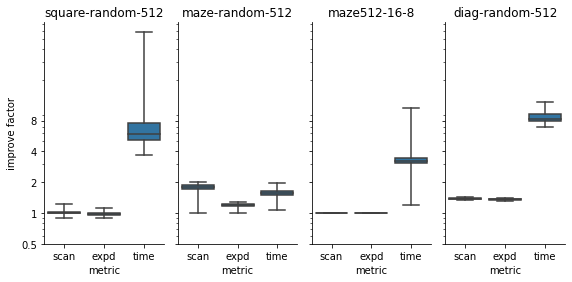

In [37]:

# sns.boxplot(x="map", y="var", hue="type", data=tot)
g = sns.FacetGrid(t2, col="map", height=4, aspect=.5)
g.map(sns.boxplot, "metric", "improve factor", whis=[0, 100], order=["scan", "expd", "time"])
axes = g.axes.flatten()
axes[0].set_title("square-random-512")
axes[1].set_title("maze-random-512")
axes[2].set_title("maze512-16-8")
axes[3].set_title("diag-random-512")
g.set(yscale="log")
plt.yticks([0.5, 1, 2, 4, 8], ['0.5', '1', '2', '4', '8'])
g.savefig("./output/figs/synthetic.pdf")

In [8]:
dft = df.groupby("map")["time_r"].describe().round(2).drop(["count", "mean", "std"], axis=1)
dft

,min,25%,50%,75%,max
map,,,,,
diag-random-512,0.10,0.12,0.12,0.13,0.15
maze-random,0.50,0.63,0.64,0.67,1.02
maze512-16-8,0.09,0.28,0.30,0.31,0.84
square-random-512,0.02,0.14,0.18,0.20,0.28


In [10]:
dfs = df.groupby("map")["scnt_r"].describe().round(2).drop(["count", "mean", "std"], axis=1)
dfs

,min,25%,50%,75%,max
map,,,,,
diag-random-512,1.99,2.18,2.22,2.39,2.57
maze-random,0.38,3.33,3.49,4.11,4.65
maze512-16-8,1.04,1.19,1.24,1.28,1.89
square-random-512,0.22,0.70,0.87,1.05,2.19


In [11]:
dfe = df.groupby("map")["expd_r"].describe().round(2).drop(["count", "mean", "std"], axis=1)
dfe

,min,25%,50%,75%,max
map,,,,,
diag-random-512,2.99,3.09,3.11,3.13,3.23
maze-random,1.00,1.59,1.64,1.67,1.75
maze512-16-8,1.00,1.00,1.00,1.00,1.00
square-random-512,1.00,1.31,1.46,1.55,2.30


In [45]:
print("time improvement\n", dft.to_latex(), "scan improvement\n", dfs.to_latex(), "expd improvement\n", dfe.to_latex())

time improvement
 \begin{tabular}{lrrrrr}
\toprule
{} &   min &   25\% &   50\% &   75\% &   max \\
map               &       &       &       &       &       \\
\midrule
diag-random-512   &  1.34 &  2.18 &  2.24 &  2.32 &  2.60 \\
maze-random       &  0.97 &  1.41 &  1.46 &  1.50 &  1.70 \\
maze512-16-8      &  0.56 &  0.93 &  0.93 &  0.94 &  1.23 \\
square-random-512 &  0.87 &  1.12 &  1.25 &  1.31 &  1.89 \\
\bottomrule
\end{tabular}
 scan improvement
 \begin{tabular}{lrrrrr}
\toprule
{} &   min &   25\% &   50\% &   75\% &   max \\
map               &       &       &       &       &       \\
\midrule
diag-random-512   &  2.44 &  2.48 &  2.50 &  2.53 &  2.68 \\
maze-random       &  1.00 &  1.86 &  1.95 &  1.97 &  2.11 \\
maze512-16-8      &  1.00 &  1.00 &  1.00 &  1.00 &  1.00 \\
square-random-512 &  1.00 &  1.12 &  1.25 &  1.37 &  2.79 \\
\bottomrule
\end{tabular}
 expd improvement
 \begin{tabular}{lrrrrr}
\toprule
{} &   min &   25\% &   50\% &   75\% &   max \\
map               

# Domain experiment

In [9]:
# rect = pd.concat([load_df("output/rect/"+i) for i in os.listdir("output/rect")])
jps = pd.concat([load_df("output_rebuttal/jps/"+i) for i in os.listdir("output_rebuttal/jps")])
jpsp = pd.concat([load_df("output/jps-prune/"+i) for i in os.listdir("output_rebuttal/jps-prune")])
# jps2 = pd.concat([load_df("output/jps2/"+i) for i in os.listdir("output/jps2")])
# jps2p = pd.concat([load_df("output/jps2-prune/"+i) for i in os.listdir("output/jps2-prune")])

In [10]:
df = pd.DataFrame.merge(jpsp, jps, on=["id","map", "domain"], suffixes=("", "_jps"))
# sanity checking
(df["cost"] - df["cost_jps"]).describe()

count    178120.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

In [11]:
df["ratio_t"] = df["time_jps"] / df["time"]
df["ratio_s"] = df["scnt_jps"] / df["scnt"]
df["ratio_g"] = df["expd_jps"] / df["expd"]
t = df[["ratio_t", "ratio_s", "ratio_g", "map", "cost", "expd", "domain", "expd_jps", "scnt_jps"]]
t.head()

,ratio_t,ratio_s,ratio_g,map,cost,expd,domain,expd_jps,scnt_jps
0,3.600576,1.0,1.0,scene_sp_rus_01,2.4142,2,iron,2,26
1,3.582240,1.0,1.0,scene_sp_rus_01,3.4142,2,iron,2,14
2,6.095073,1.0,1.0,scene_sp_rus_01,3.4142,2,iron,2,53
3,19.615809,1.0,1.0,scene_sp_rus_01,3.4142,2,iron,2,25
4,3.920000,1.0,1.0,scene_sp_rus_01,1.4142,1,iron,1,9


In [12]:
t.groupby("domain")["ratio_t"].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
domain,,,,,,,,
bgmaps,122600.0,47.02,52.32,0.14,12.45,27.65,61.02,506.46
iron,55520.0,12.56,19.50,0.27,5.52,7.30,10.78,301.15


In [13]:
t.groupby("domain")["ratio_g"].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
domain,,,,,,,,
bgmaps,122586.0,0.97,0.05,0.47,0.96,1.00,1.0,1.18
iron,55513.0,0.95,0.05,0.63,0.91,0.96,1.0,1.33


In [17]:
print(t.groupby("domain")["ratio_t"].describe().round(2).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &     count &   mean &    std &   min &    25\% &    50\% &    75\% &     max \\
domain &           &        &        &       &        &        &        &         \\
\midrule
bgmaps &  122600.0 &  47.02 &  52.32 &  0.14 &  12.45 &  27.65 &  61.02 &  506.46 \\
iron   &   55520.0 &  12.56 &  19.50 &  0.27 &   5.52 &   7.30 &  10.78 &  301.15 \\
\bottomrule
\end{tabular}



TypeError: 'AxesSubplot' object is not subscriptable

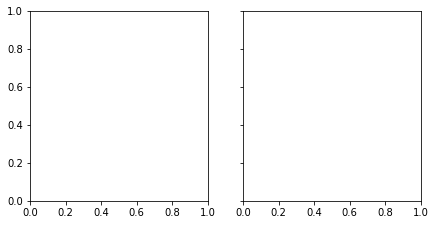

In [16]:
domains = t["domain"].unique()
ndomain = len(domains)
minexpd = 200
mincost = 100
nrows   = 1
ncols   = ndomain // nrows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=(3.5*ncols, 3.5*nrows))
if ndomain == 1:
    axes = [axes]
colors = sns.color_palette()

for i in range(ndomain):
    g = t[t["domain"] == domains[i]]
    g = g[g["expd_jps"] > minexpd]
    axi = axes[i // ncols][i % ncols]
    g = sns.scatterplot(x="expd_jps", y="ratio_t", color=colors[i], data=g, ax=axi, s=1)

    g.axhline(1, color="black")
    axi.grid()
    axi.set_yscale("linear")
    axi.set_xlabel("")
    axi.set_ylabel("")
    axi.set_title(domains[i])
    axi.set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])
    axi.set_ylim([0, 2])

for i in range(nrows):
    axes[i][0].set_ylabel("speed up factor")
for i in range(ncols):
    axes[nrows-1][i].set_xlabel("jps expd")
fig.savefig("./output/figs/domain_cmp.png")

In [21]:
z = (df.groupby("domain")[["time", "time_jps"]].sum() / 1000000).round(2)
z

,time,time_jps
domain,,
bgmaps,3.32,3.20
dao,13.20,14.63
iron,6.83,7.07
maze512,722.54,684.96
random10,14.62,14.91
rooms,27.96,25.81
starcraft,33.80,34.73
street,15.32,14.92


In [127]:
print(z.to_latex())

\begin{tabular}{lrr}
\toprule
{} &    time &  time\_jps \\
domain    &         &           \\
\midrule
bgmaps    &    3.17 &      3.23 \\
dao       &   40.13 &     47.26 \\
iron      &    6.31 &      7.21 \\
maze512   &  691.46 &    672.37 \\
random10  &   13.86 &     15.06 \\
rooms     &   25.79 &     25.68 \\
starcraft &   31.30 &     34.66 \\
street    &   14.38 &     15.12 \\
\bottomrule
\end{tabular}



# Best and Worst of each Domain

In [67]:
df["time_r"] = df["time_jps"] / df["time"]
df["scnt_r"] = df["scnt_jps"] / df["scnt"]
df["expd_r"] = df["expd_jps"] / df["expd"]

In [70]:
dfm= df.groupby(["map", "domain"]).median().reset_index()
metric = "scnt_r"

idx = dfm.groupby(["domain"])[metric].transform(max) == dfm[metric]
dmax = dfm[idx]

idx = dfm.groupby(["domain"])[metric].transform(min) == dfm[metric]
dmin = dfm[idx]

In [23]:
df.columns

Index(['id', 'alg', 'expd', 'gend', 'touched', 'time', 'cost', 'scnt', 'sfile',
       'map', 'domain', 'alg_jps', 'expd_jps', 'gend_jps', 'touched_jps',
       'time_jps', 'cost_jps', 'scnt_jps', 'sfile_jps', 'ratio_t', 'ratio_s',
       'ratio_g', 'time_r', 'scnt_r', 'expd_r'],
      dtype='object')

In [71]:
dmax[dmax["scnt_r"] > 1][["map", "domain", "time_r", "scnt_r", "expd_r"]]

,map,domain,time_r,scnt_r,expd_r
31,8room_001,rooms,0.870329,1.492695,1.004902
80,AR0404SR,bgmaps,0.894088,1.414760,1.026320
134,Boston_0_256,street,0.802549,1.271191,1.000000
175,IceMountain,starcraft,1.048191,1.397845,1.015955
452,maze512-8-8,maze512,0.860471,1.347400,1.000000
464,orz203d,dao,0.922327,2.166667,1.000000
494,random512-10-1,random10,1.058688,2.111705,1.022246
529,scene_sp_rus_03,iron,0.928820,1.461790,1.024000


dmin[["map", "domain", "time_r", "scnt_r", "expd_r"]]

# Visualize Map

In [5]:
from matplotlib.patches import Rectangle

In [19]:
# files = [i for i in os.listdir("./output") if i.endswith(".csv")]
files = [
    "maze512.csv", 
    "room.csv",
    "endmaps.csv", 
    "GreenerPastures.csv", 
]
df = pd.concat([pd.read_csv("./output/"+i, sep="\t") for i in files])
df.head()

,map,mapw,maph,x,y,traversable
0,../maps/maze512/maze512-32-0.map,512,512,0,0,1
1,../maps/maze512/maze512-32-0.map,512,512,1,0,1
2,../maps/maze512/maze512-32-0.map,512,512,2,0,1
3,../maps/maze512/maze512-32-0.map,512,512,3,0,1
4,../maps/maze512/maze512-32-0.map,512,512,4,0,1


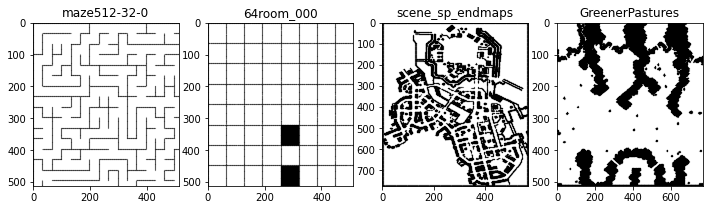

In [20]:
maps = df["map"].unique()
nmap = len(maps)
fig, axes = plt.subplots(nrows=1, ncols=nmap, figsize=(nmap*3, 3), sharex=False, sharey=False)
if nmap == 1:
    axes = [axes]
for i, m in enumerate(maps):
    g = df[(df["map"] == m)]
    axes[i].set_xlim(0, g["mapw"].min())
    axes[i].set_ylim(0, g["maph"].min())
    axes[i].invert_yaxis()
    axes[i].scatter(x=g[g["traversable"] == 1]["x"], y=g[g["traversable"] == 1]["y"], c="black", s=0.01)
    axes[i].set_title(m.split("/")[-1].removesuffix(".map"))

plt.savefig("./output/figs/visual_maps.png")